# Model Selection, Training, and Hyperparameter Tuning

### H2O AutoML
###### offers a comprehensive solution for automating the machine learning workflow. By handling model selection, hyperparameter tuning, and feature engineering, it allows users to efficiently build high-performance models with minimal manual intervention. The leaderboard and stacked ensembles further enhance its effectiveness by providing insights into model performance and combining multiple models for better results.

In [1]:
!pip install h2o


In [2]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from h2o.explanation import explain
from h2o.automl import H2OAutoML

import pandas as pd
import warnings
import h2o
import pandas as pd
# Hide all warnings
warnings.filterwarnings('ignore')

In [12]:


# Initialize H2O cluster
h2o.init()
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Split the DataFrame into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # 20% for testing

# Save the DataFrames to CSV files
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("Training data saved to 'train_data.csv'")
print("Test data saved to 'test_data.csv'")

h2o_df = h2o.H2OFrame(train_df)

# Split dataset into training and test sets
train, test = h2o_df.split_frame(ratios=[.8])

# Define target and features
target = 'Survived'
features = h2o_df.columns
features.remove(target)

# Train H2O AutoML
aml = H2OAutoML(max_runtime_secs=60, seed=123, max_models=5)  # AutoML will run for 1 hour
aml.train(x=features, y=target, training_frame=train)

# View leaderboard
lb = aml.leaderboard
print("Leaderboard:")
print(lb.head())

# Get the best-performing model (leader model)
leader_model = aml.leader
# Print specific hyperparameters if known
print("Hyperparameters for the leader model:")
params = leader_model.params

for param, value in params.items():
      print(f"{param}: {value}")

# Get the leader model
leader_model = aml.leader

# Print the model ID and type
print("Model ID:", leader_model.model_id)
print("Model Type:", leader_model.algo)

# Get and print the leaderboard
lb = aml.leaderboard



# Get detailed model summary
print("Leader Model Summary:")
print(leader_model.summary())

# Get the best model
best_model = aml.leader

# Make predictions on the test set
predictions = best_model.predict(test)

# Evaluate the best model
performance = best_model.model_performance(test)
print(performance)

# Save the best model
best_model_path = h2o.save_model(model=best_model, path="./best_model", force=True)
print(f"Model saved to: {best_model_path}")






Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -------------------------------
H2O_cluster_uptime:         12 mins 47 secs
H2O_cluster_timezone:       Asia/Kolkata
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.5
H2O_cluster_version_age:    20 days
H2O_cluster_name:           H2O_from_python_preethas_i7kf6k
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    15.78 Gb
H2O_cluster_total_cores:    20
H2O_cluster_allowed_cores:  20
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.9 final
--------------------------  -------------------------------

Training data saved to 'train_data.csv'
Test data saved to 'test_data.csv'
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:36:56.166: AutoML: XGBoost is not available; skipping it.
14:36:56.168: _train param, Dropping bad and constant columns: [Name]
14:36:56.168: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
14:36:56.273: _train param, Dropping bad and constant columns: [Name]
14:36:56.273: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
14:36:56.392: _train param, Dropping bad and constant columns: [Name]
14:36:56.392: _response param, We have detected that your response column h

# Explainable AI using H2O's built-in tools

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

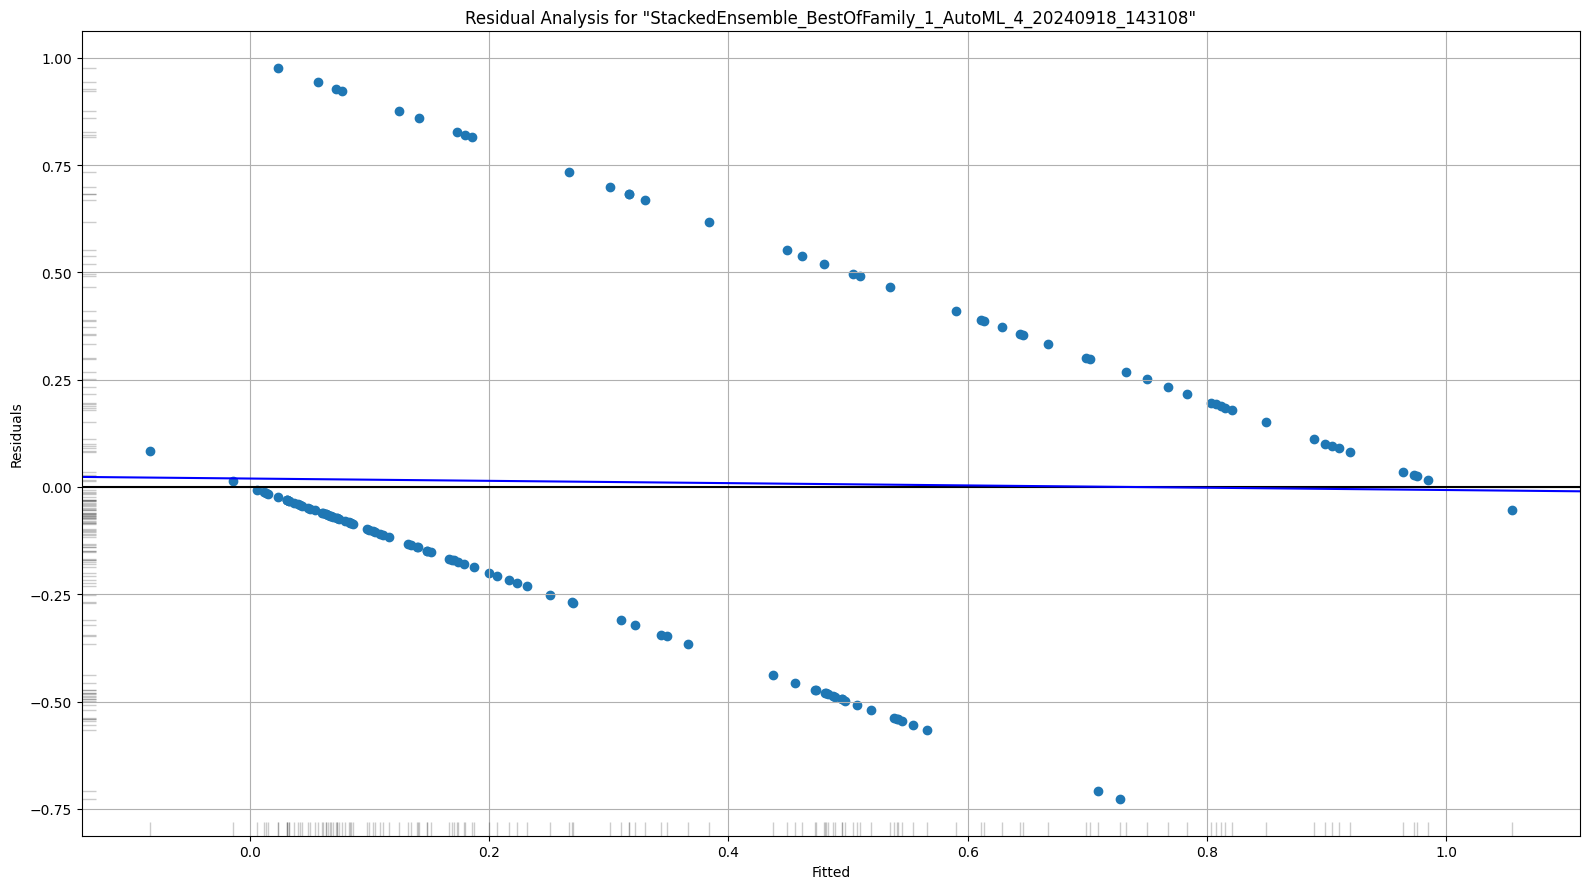

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

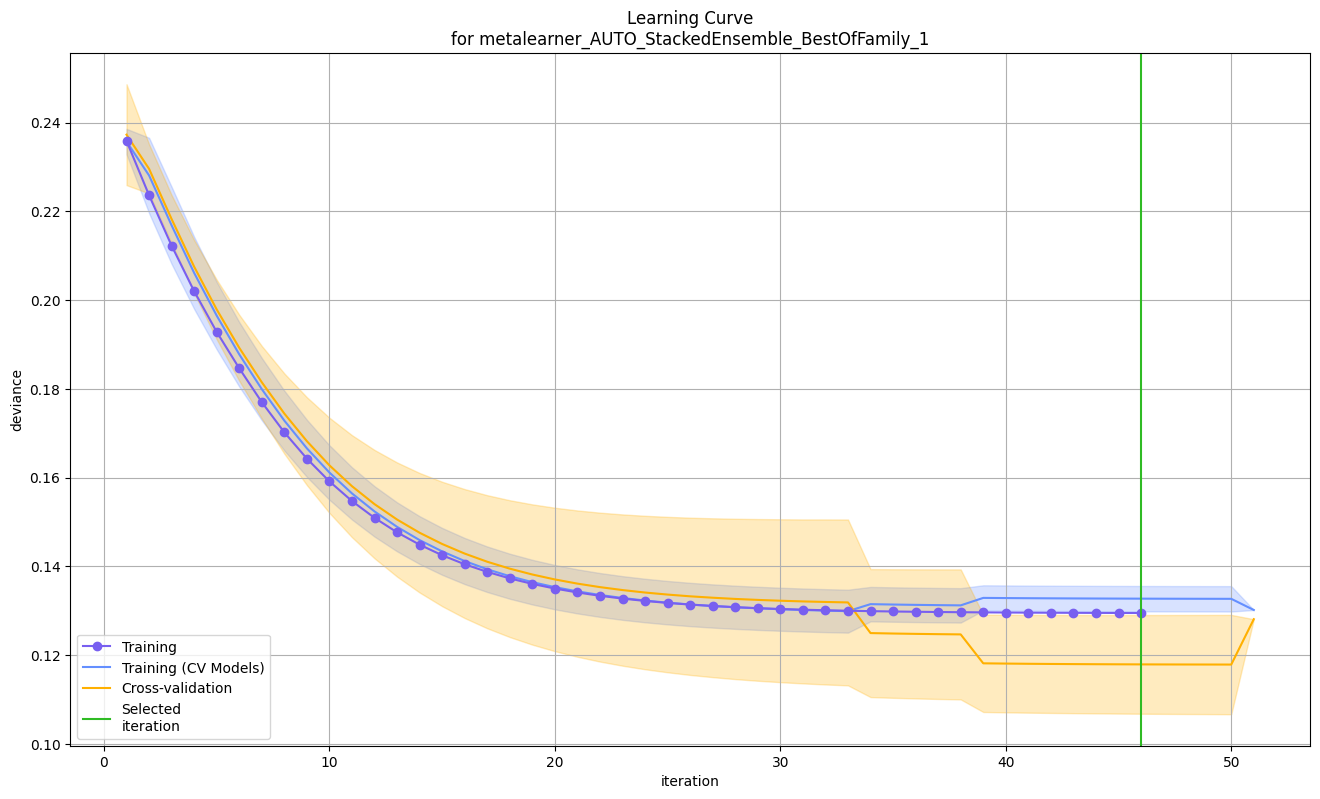

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

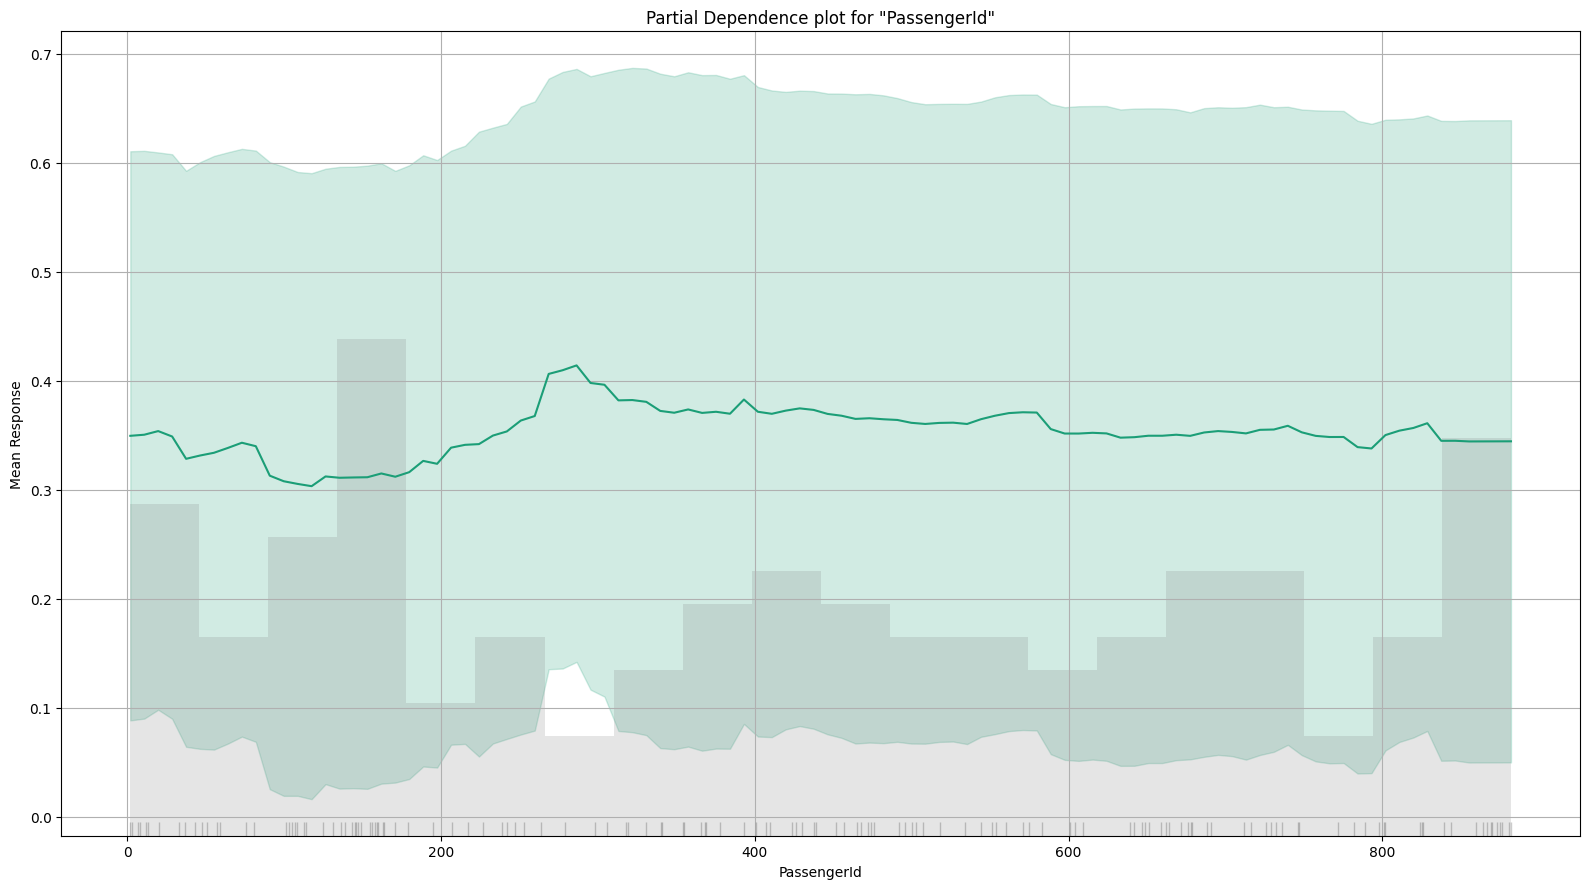

In [ ]:
# Explain model using H2O's built-in tools
explanations = explain(best_model, test)
print(explanations)

In [13]:
# Load the saved model
loaded_model = h2o.load_model(best_model_path)

# Load new data for prediction
new_data = h2o.import_file('test_data.csv')
print(new_data.head())

# Separate true labels if they are included in new_data
true_labels = new_data['Survived'].as_data_frame()
true_labels_df = true_labels

# Make predictions with the loaded model
predictions = loaded_model.predict(new_data)

# Convert to pandas DataFrame (if needed)
predictions_df = predictions.as_data_frame()
# Assuming the prediction column is named 'predict'
predictions_df['predicted_class'] = (predictions_df['predict'] >= 0.5).astype(int)
# Show predictions
print(predictions_df.head())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  PassengerId    Survived    Pclass  Name                                               Sex       Age    SibSp    Parch    Ticket     Fare  Cabin    Embarked
          710           1         3  Moubarek, Master. Halim Gonios ("William George")  male      nan        1        1      2661  15.2458           C
          440           0         2  Kvillner, Mr. Johan Henrik Johannesson             male       31        0        0       nan  10.5              S
          841           0         3  Alhomaki, Mr. Ilmari Rudolf                        male       20        0        0       nan   7.925            S
          721           1         2  Harper, Miss. Annie Jessie "Nina"                  female      6        0        1    248727  33                S
           40           1         3  Nicola-Yarred, Miss. Jamila                        female     14        1        0      2651  11.2417     

# Evaluating the model

In [14]:
# Calculate accuracy
accuracy = accuracy_score(true_labels_df, predictions_df['predicted_class'])
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_df, predictions_df['predicted_class'])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.7932960893854749
Confusion Matrix:
[[94 11]
 [26 48]]


In [15]:
# Shutdown the H2O cluster
h2o.shutdown()

H2O session _sid_84d6 closed.
